# Lecture EXTRA: Determining a Pathway to Fast Charge
---
## Motivation
A goal for modern electric vehicles is to have the effective charge rate match that of refueling a gas tank. What is required from both the charger and the battery to get this done?

We'll use some back of the envelope estimate and dualfoil to determine what engineering pathway might get us there.

In [2]:
import sys
sys.path.append("/pithy/code")
from pithy import *
import dualfoil
import sympy
%matplotlib inline

## The Charger
When we pump gasoline into a tank, how do we get an equivalent charge rate?

Let's take the energy density of gasoline, and assume a 2 minute fill up for a 16 gallon tank.

In [3]:
from sympy.physics.units import *
gallon = 3.78541*liter
ed_gasoline = 1.3e8 *J/gallon
fill_time = 120 * second
tank_size = 16 * gallon
power_req = ed_gasoline * tank_size/fill_time
megawatt = 1e6*watt
rate = convert_to(power_req,megawatt)
pump_to_wheels = .2
print "Fuel Power:",rate,', Effective Power',pump_to_wheels*rate

Fuel Power: 17333333.3333333*watt , Effective Power 3466666.66666667*watt


This is a rate of charge of 17 **MW**. Even assuming a pump to wheels efficiency of 20%, this is ~3.5MW from a single charge station. 

By way of comparison, a level three charger is currently ~80 **kW**. So this charging infrastructure is a non-trivial step beyond where we are now.

Let's take a look at the battery

## The Battery

So how do we determine what configuration of battery might get us to such an effective charge rate?

Let's first take the standard configuration in dualfoil, discharge it at a slow rate (to determine maximum capacity), and then charge it at a rate that should get us to two minutes to fill.

In [4]:
#instantiate simulator
df = dualfoil.dualfoil("user")

In [5]:
rate = 1 #A/m^2
df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output

0

In [6]:
data = df.readOutput()
discharge_time = max(data['t'])-min(data['t'])
discharge_time 

1416.8969999999999

So, in order to find a rate that gets us to 2 minutes full up:

In [7]:
target_time = 2.0
fast_rate = rate*discharge_time/target_time

Now, let's rebuild a cycling protocol to test this out. We'll put a potential hold after the run to "top" off the battery

   Time     Util N  Util P  Cell Pot   Uocp      Curr      Temp   heatgen
   (min)       x       y      (V)       (V)      (A/m2)    (C)    (W/m2)
    1.012, 0.5996, 0.5002,  4.06090,  4.06244,     1.00,  24.85,   0.00, 
   53.862, 0.5777, 0.5131,  4.04944,  4.05123,     1.00,  24.85,   0.00, 
   82.590, 0.5657, 0.5201,  4.03869,  4.04092,     1.00,  24.85,   0.00, 
  111.318, 0.5538, 0.5270,  4.01336,  4.01589,     1.00,  24.85,   0.00, 
  168.773, 0.5300, 0.5410,  3.99138,  3.99332,     1.00,  24.85,   0.00, 
  197.501, 0.5181, 0.5480,  3.98162,  3.98386,     1.00,  24.85,   0.00, 
  226.229, 0.5062, 0.5549,  3.96454,  3.96716,     1.00,  24.85,   0.00, 
  254.957, 0.4942, 0.5619,  3.93936,  3.94225,     1.00,  24.85,   0.00, 
  283.685, 0.4823, 0.5689,  3.91053,  3.91337,     1.00,  24.85,   0.00, 
  341.141, 0.4585, 0.5828,  3.86787,  3.87001,     1.00,  24.85,   0.00, 
  369.868, 0.4466, 0.5898,  3.85684,  3.85874,     1.00,  24.85,   0.00, 
  398.596, 0.4346, 0.5968,  3.84938,  3

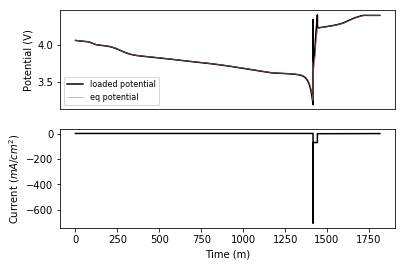

In [8]:
df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.set_current(0,10,minv=3.2) #relax
df.set_current(-1*fast_rate,100000000,maxv=4.4) #negative rates = charge
df.set_current(-.1*fast_rate,10000000,maxv=4.4)
df.set_current(-1*rate,1000,maxv=4.4)
df.set_potential(4.4,100)
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
df.ivtplot(ir_emph=True)


As we can see from the figure above and the utilization calculation, this battery is really quite impeding at the rate required to fill the cell up in two minutes. As a guess, let's try to reduce the thickness of the electrodes to encourage a faster charge. In the script below, we'll run the simulation twice in one go to get the full capacity and then set the charge rate